In [90]:
# import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
# Load Dataset
churn_path='/content/drive/MyDrive/churnlexdev/MOCK_DATA (6).csv'
dev=pd.read_csv(churn_path)

In [93]:
dev.head()

,customer_id,age,gender,total_purchases,last_purchase_date,average_purchase_amount,customer_segment,customer_satisfaction,customer_engagement,customer_complaints,churned
0,1.0,39.0,Male,80.0,5/30/2019,349.32,high-value,5.0,2.0,1.0,False
1,2.0,78.0,Female,547.0,4/20/2021,7061.24,low-value,2.0,64.0,8.0,True
2,3.0,63.0,Female,129.0,7/25/2020,1593.08,high-value,5.0,19.0,2.0,True
3,4.0,75.0,Female,245.0,2/20/2021,5118.42,mid-value,2.0,47.0,8.0,True
4,5.0,38.0,Male,440.0,5/19/2019,1033.53,mid-value,5.0,78.0,3.0,True


In [94]:
dev.isnull().sum()

customer_id                1000
age                        1000
gender                        0
total_purchases            1000
last_purchase_date         1000
average_purchase_amount    1000
customer_segment           1000
customer_satisfaction      1000
customer_engagement        1000
customer_complaints        1000
churned                    1000
dtype: int64

In [95]:
dev.shape

(2000, 11)

<Axes: >

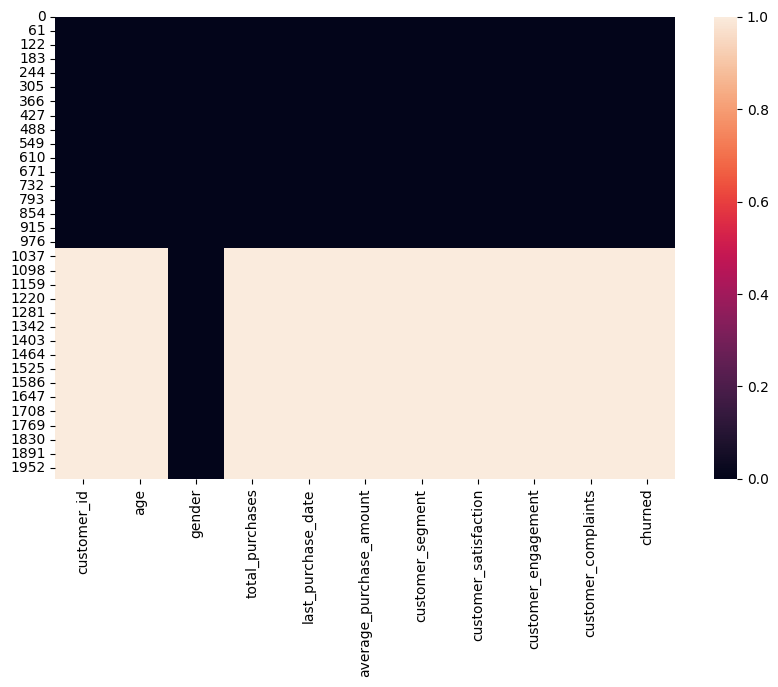

In [96]:
plt.figure(figsize=(10,6))
sns.heatmap(dev.isnull())

In [97]:
# since the missing values are missing not completely at random, then we can drop them
dev=dev.dropna()
dev.shape

(1000, 11)

In [98]:
dev.dtypes

customer_id                float64
age                        float64
gender                      object
total_purchases            float64
last_purchase_date          object
average_purchase_amount    float64
customer_segment            object
customer_satisfaction      float64
customer_engagement        float64
customer_complaints        float64
churned                     object
dtype: object

In [99]:
# Lets convert categorical columns to numerical dtypes,
# lets first check categorical columns then convert them
categorical_columns=dev.select_dtypes(include='object')
categorical_columns

,gender,last_purchase_date,customer_segment,churned
0,Male,5/30/2019,high-value,False
1,Female,4/20/2021,low-value,True
2,Female,7/25/2020,high-value,True
3,Female,2/20/2021,mid-value,True
4,Male,5/19/2019,mid-value,True
...,...,...,...,...
995,Female,4/3/2021,high-value,False
996,Female,1/10/2020,high-value,True
997,Bigender,2/21/2019,mid-value,True
998,Male,10/6/2021,low-value,False


In [100]:
dev['gender'].unique()

array(['Male', 'Female', 'Non-binary', 'Genderfluid', 'Agender',
       'Bigender', 'Polygender', 'Genderqueer'], dtype=object)

In [101]:
# Encode categorical columns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# we will use OneHot To Encode Gender column and LabelEncoder to Encode customer_segment then convert last_purchase_date into datetime and get valuable values like year,month,day

# convert churned column(target column) to numerical, False == 0, True == 1
dev['churned']=dev['churned'].replace({False: 0, True: 1})

# Lets use LabelEncoder for 'customer_segment'
label_encoder = LabelEncoder()
dev['customer_segment_encoded'] = label_encoder.fit_transform(dev['customer_segment'])

# lets convert date to datetime into year, month, day
dev['last_purchase_date'] = pd.to_datetime(dev['last_purchase_date'])
dev['year'] = pd.to_datetime(dev['last_purchase_date']).dt.year
dev['month'] = pd.to_datetime(dev['last_purchase_date']).dt.month
dev['day'] = pd.to_datetime(dev['last_purchase_date']).dt.day

# Lets use OneHotEncoder for 'gender'
onehot_encoder = OneHotEncoder(sparse=False)
gender_encoded = onehot_encoder.fit_transform(dev[['gender']])
gender_encoded_df = pd.DataFrame(gender_encoded, columns=['gender_' + str(int(i)) for i in range(gender_encoded.shape[1])])

# Concatenate the encoded columns back to the original DataFrame
dev_encoded = pd.concat([dev, gender_encoded_df], axis=1)

# Lets drop the original gender and customer_segment
dev_encoded = dev_encoded.drop(['gender', 'customer_segment', 'last_purchase_date'], axis=1)


In [102]:
# Model Selection
# we will use ensemble models for there high accuracy..LightGbm,Xgboost,Catboost,RandomForest
# we are not going to draw Feature importance plot since we assume all features are important in predicting our target since there are few features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


In [103]:
final=dev_encoded.drop('customer_id',axis=1)
final.shape

(1000, 19)

In [104]:
scaler=MinMaxScaler()
dev_scaled=scaler.fit_transform(final)
dev_scaled.shape

(1000, 19)

In [109]:
dev_scaled_df = pd.DataFrame(dev_scaled, columns=final.columns)
dev_scaled_df


,age,total_purchases,average_purchase_amount,customer_satisfaction,customer_engagement,customer_complaints,churned,customer_segment_encoded,year,month,day,gender_0,gender_1,gender_2,gender_3,gender_4,gender_5,gender_6,gender_7
0,0.313433,0.080,0.034637,1.00,0.02,0.1,0.0,0.0,0.0,0.363636,0.966667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.895522,0.547,0.706294,0.25,0.64,0.8,1.0,0.5,1.0,0.272727,0.633333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.671642,0.129,0.159099,1.00,0.19,0.2,1.0,0.0,0.5,0.545455,0.800000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.850746,0.245,0.511877,0.25,0.47,0.8,1.0,1.0,1.0,0.090909,0.633333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.298507,0.440,0.103105,1.00,0.78,0.3,1.0,1.0,0.0,0.363636,0.600000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.925373,0.224,0.162776,1.00,0.75,0.3,0.0,0.0,1.0,0.272727,0.066667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
996,0.388060,0.209,0.533430,0.50,0.11,0.1,1.0,0.0,0.5,0.000000,0.300000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
997,0.850746,0.675,0.555345,1.00,0.51,0.4,1.0,1.0,0.0,0.090909,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.059701,0.536,0.442880,0.75,0.61,0.4,0.0,0.5,1.0,0.818182,0.166667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [113]:
X=dev_scaled_df.drop('churned',axis=1)
y=dev_scaled_df['churned']

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

#model=RandomForestClassifier(random_state=42)
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [114]:
X.shape,y.shape

((1000, 18), (1000,))

In [115]:
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test, y_pred)
accuracy

0.545